# Анализ бизнеса. Исследование метрик юнит-экономики.

Мы являемся маркетинговым аналитиком развлекательного приложения Procrastinate Pro+. Несколько прошлых месяцев наш бизнес постоянно нес убытки - в привлечение пользователей была вложена куча денег, а толку никакого. Нам нужно разобраться в причинах этой ситуации.

В нашем распоряжении есть лог сервера с данными о посещениях приложения новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27, выгрузка их покупок за этот период, а также статистика рекламных расходов. Нам предстоит изучить, как люди пользуются продуктом, когда они начинают покупать, сколько денег приносит каждый клиент, когда он окупается и какие факторы отрицательно влияют на привлечение пользователей.

**Цели исследования:**

* Через пользовательские профили посмотреть страну, устройства входа, рекламный источник с определением доли платящих пользователей.
* Рассчитать расходы на маркетинг и среднее на привлечение одного пользователя
* С помощью LTV и ROI рассчитать окупаемость рекламы 
* Построить и изучить графики конверсии и удержания
* Выделить причины неэффективности привлечения пользователей
* Сформулируйте рекомендации для отдела маркетинга

**Ход исследования:**
Изучить и обработать данные. Собрать из данных профили пользователей и рассчитать долю платящих с разбивкой по целям исследования. Рассмотреть затраты на каналы. Рассчитать ROI и LTV и построить по ним графики. Сделать общий вывод.

## Изучение и обработка данных

В первую очередь подключаем библиотеки, которые в дальнейшем нам понадобятся:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import numpy as np

Откроем данные с файлами.

Посмотрим на таблицу с посещениями сайта.


В данных отсуствуют пропуски. Заголовки для удобства перепишем в удобный формат.

In [5]:
visits.columns = visits.columns.str.lower()
visits = visits.rename(columns={'user id' : 'user_id', 'session start' : 'session_start', 'session end' : 'session_end'})

Посмотрим на таблицу с информацией по покупкам.



Аналогично отсуствую пропуски и также требуется переписать название колонок.

Посмотрим на таблицу с расходами на рекламу.



Данные также без пропусков и также требуется переписать название колонок.

In [11]:
costs.columns = costs.columns.str.lower()

Посмотрим имеются ли среди данных дубликаты.

In [12]:
print('Количество дупликатов visits:',visits.duplicated().sum()) 
print('Количество дупликатов orders:',orders.duplicated().sum())
print('Количество дупликатов costs:',costs.duplicated().sum())

Количество дупликатов visits: 0
Количество дупликатов orders: 0
Количество дупликатов costs: 0


Для удобства работы с датами, в каждой таблице поменяем тип данных в нужных для нас колонках.

In [13]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date 

Теперь мы можем приступить непосредственно к анализу.

### Вывод 

Перед нами качественные данные, с отсуствием пропусков и дубликатов. Для удобства мы изменили название некоторых колонок, привели их к нижнему регистру и заменили пробелы нижним слэшем. Колонки с датами мы привели к типу `datetime`.

## Анализ данных

### Профили пользователей

Для построение профилей пользователей мы используем отдельно функцию которая учтёт первые посещения пользователи и траты на рекламу .

In [14]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())


    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles


Рассмотрим первые 10 строк таблицы профилей: 

In [15]:
profiles = get_profiles(visits, orders, costs)
profiles.head(10)

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769
5,34186288,2019-05-09 17:29:23,organic,Android,United States,2019-05-09,2019-05-01,False,0.000000
6,38448301,2019-08-16 11:56:00,organic,Android,United States,2019-08-16,2019-08-01,False,0.000000
7,46006712,2019-06-30 03:46:29,AdNonSense,Android,France,2019-06-30,2019-06-01,True,1.008000
8,58263264,2019-05-11 19:18:43,FaceBoom,iPhone,United States,2019-05-11,2019-05-01,False,1.128205
9,59835779,2019-05-11 21:13:47,MediaTornado,iPhone,United States,2019-05-11,2019-05-01,False,0.250435


Посмотрим на минимальную и максимальную дату привлечения пользователя.

In [16]:
print('Минимальная дата привлечения:', profiles['dt'].min())
print('Максимальная дата привлечения:', profiles['dt'].max())

Минимальная дата привлечения: 2019-05-01
Максимальная дата привлечения: 2019-10-27


Даты совпадают с логами сервера данных о посещениях приложения новыми пользователями.

Следующие разбивки примерно буду похожи между собой. Напишем функцию под наши целию.

In [17]:
def group_by(column):
    return (
         profiles
        .groupby(column)
        .agg({'user_id' : 'nunique', 'payer' : 'mean'})
        .sort_values('user_id',ascending=False)
        .round(3)
    )
   
     

Посмотрим на профили с разбивкой по странам.

In [18]:
group_by('region')

,user_id,payer
region,,
United States,100002,0.069
UK,17575,0.040
France,17450,0.038
Germany,14981,0.041


Основной приток пользователей, в том числе и платящих, идёт из США. Стоит также обратить внимание что хоть и Германия находится в конце по количеству пользователей, доля платящих выше по сравнению с Францией и Британией.

Посмотрим профили с разбивкой по устройствам.

In [19]:
group_by('device')

,user_id,payer
device,,
iPhone,54479,0.062
Android,35032,0.059
PC,30455,0.050
Mac,30042,0.064


Большинство пользователей заходит через iPhone. Стоит также обратить внимание что доля платящих выше всего для Mac, хотя количество пользователей практически в два раза меньше пользователей iPhone. 

Рассмотрим последнюю разбивку по рекламным каналам.

In [20]:
group_by('channel')

,user_id,payer
channel,,
organic,56439,0.021
FaceBoom,29144,0.122
TipTop,19561,0.096
OppleCreativeMedia,8605,0.027
LeapBob,8553,0.031
WahooNetBanner,8553,0.053
RocketSuperAds,4448,0.079
MediaTornado,4364,0.036
YRabbit,4312,0.038


Основные рекламные каналы привлечения являются FaceBoom и TipTop. Хотя самое большое количество пользователей пришли самостоятельно. Построем столбчатую диаграмму для просмотра доли платящих пользователей. 

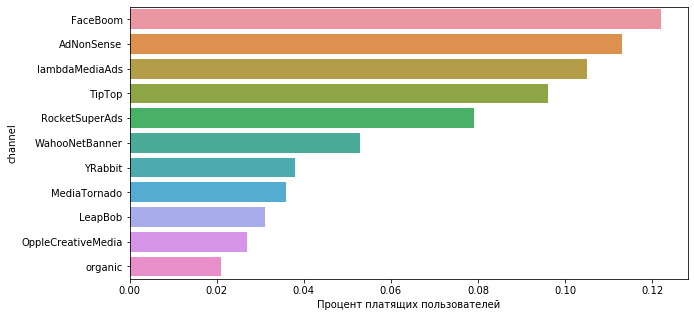

In [21]:
plt.figure(figsize=(10,5))
channel = group_by('channel').sort_values('payer', ascending=False)
sns.barplot(x = channel['payer'], y = channel.index)
plt.xlabel('Процент платящих пользователей')
plt.show()

Стоит обратить внимание, что для AdNonSense и lambdaMediaAds высокие доли платящих при этом количество пользователей из этих источников в несколько раз меньше TipTop. 

### Вывод

Основной регион пользователей приходит из США. А самым популярным устройством яляется хоть и iPhone, платящих пользователей больше на Mac. Основные каналы привлечения является "естественный", FaceBoom и TipTop. При этом FaceBoom имеет самую высокую долю платящих. 

<div style="border:solid Green 2px; padding: 10px"> 
<font style="color:Green; font-size:100%";> ✔️ Комментарий ревьюера:</font> Верно
    
    
</div>

## Маркетинг

Рассмотрим общие траты на маркетинг по источникам.

In [22]:
profiles.groupby('channel')['acquisition_cost'].sum().sort_values(ascending=False)

channel
TipTop                54751.30
FaceBoom              32445.60
WahooNetBanner         5151.00
AdNonSense             3911.25
OppleCreativeMedia     2151.25
RocketSuperAds         1833.00
LeapBob                1797.60
lambdaMediaAds         1557.60
MediaTornado            954.48
YRabbit                 944.22
organic                   0.00
Name: acquisition_cost, dtype: float64

TipTop и FaceBoom затратили больше всего денег на маркетинг. Обратим внимание, что также у нас в данных есть профили которые пришли самостоятельно. Так как затраты на такой источник нет, то уберём его из профилей и посмотрим динамику изменений со  временем затрат на рекламу. 

In [ ]:
profiles = profiles.query('channel != "organic"')
(
    profiles.pivot_table(index='dt', columns='channel', values='acquisition_cost', aggfunc='sum')
    .plot(figsize=(15,7), grid=True)
)
plt.title('Динамика изменения затрат на рекламу')
plt.xlabel('Время')
plt.ylabel('Затраты')
plt.show()

Мы можем наблюдать, что с июня затраты FaceBoom в целом стали стабильнее, по сравнению с TipTop, где можжно наблюдать постепенный рост. Остальные каналы в целом ведут себя стабильно во времени. 

Рассмотрим стоимость привлечения клиента "CAC", рассчитав среднее для каждого канала. 

In [ ]:
(
    profiles.groupby('channel')
    .agg({'acquisition_cost': 'mean'})
    .round(3)
    .rename(columns={'acquisition_cost': 'cac'})
    .sort_values('cac',ascending=False)
)

И среднее для всего проекта.

In [ ]:
profiles['acquisition_cost'].mean().round(3)

TipTop затрачивает больше всех на рекламу в несколько раз по сравнению с другими каналами. Из-за такого влияние, среднее по всем клиентам выше всех значение кроме упомянутого TipTop. 

Посмотрим на диманиму САС по каналам привлечения.

In [ ]:
profiles.pivot_table(
    index='month', columns='channel', values='acquisition_cost', aggfunc='mean'
).plot(figsize=(15,7))
plt.ylabel('CAC')
plt.xlabel('Дата привлечения')
plt.title('Динамика САС по каналам привлечения')
plt.show()

Обратим внимание, что:
* САС для TipTop со временем только растёт
* RocketSuperAds со временем снижает затраты на рекламу 
* В целом все каналы стабильны во времени

### Вывод 

Самым высокие затраты на рекламу приносит канал TipTop и FaceBoom. При этом платящих пользователей больше именно у FaceBoom, а TipTop не входит даже в топ - 3 . При этом TipTop со времнем только увеличивал расходы на маркетинг. Полученных данных пока что недостаточно, чтобы точно давать отчёт. Требуется провести оценку окупаемости рекламы для привлечения пользователей.

## Оцените окупаемость рекламы для привлечения пользователей

С помощью LTV и ROI:
- Проанализируем общую окупаемость рекламы;
- Проанализируйем окупаемость рекламы с разбивкой по устройствам;
- Проанализируйем окупаемость рекламы с разбивкой по странам;
- Проанализируйем окупаемость рекламы с разбивкой по рекламным каналам.

Для рассчётов и анализа отдельно пропишем функции расчёта LTV и ROI и отдельно функцию для визуализации данных.

In [ ]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

In [ ]:
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [ ]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

За момент анализа, возьмём первое ноября 2019 года. А окупаемость, должна достигаться за две недели.

In [ ]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа 

Рассмотрим общую окупаемость рекламы.

In [ ]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

Что мы можем видеть на графике: 
* Реклама не окупается, значение ROI на вторую неделю достигает только 80%
* Стоимость привлечения клиентов при этом только растёт 
* Значение LTV в целом стабильны

Чтобы разобраться в причинах, рассмотрим окупаемость рекламы по каналам привлечения,устройствам и странам пользователей. 

Начнём со стран пользователей.

In [ ]:

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['region']
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

По графикам: 
* Окупаются все страны кроме США, также в динамике окупаемость США падает постепенно.
* Стоимость привлечения для США с июня только растёт, в отличии от остальных стран, которые уменьшился и стабильно держался.


Можно сделать вывод, что пользователи из США "вносят" основной вклад в общую не окупаемость проекта. Попробуем найти причина такой разницы, т.к основной поток пользователей приходит из США.

Рассмотрим графики по устройствам. 

In [ ]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['device']
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Из графикам можно увидеть: 
* Окупается со временем только пользователи с PC. Для пользователи продукции Apple окупаемость в районе 70%
* Стоимость привлечение пользователей растёт постепенно, для продукции Apple рост выше. 

По устройствам заметно что продукция Apple не окупают рекламу. Стоит обратить внимание на схожесть САС для Apple с динамикой США.

Рассмотрим окупаемость рекламы с разбивкой по каналам.

In [ ]:

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['channel']
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

По графикам: 
* Окупаеются больше половины каналов. ROI для YRabbit в динамике на летнее время имело самые высокие значения
* Самое высокое значение LTV имеется для lambdaMediaAds
* Привлечение пользователей для TipTop увеличивается со временем, остальные каналы практически стабильны во времени. 

Можно заметить схожесть графиков САС для канала TipTop c США. Видно, что такой перекос для США связан непосредственно с этим каналом. Можно попробовать про анализировать сред данных по США, исключив канал TipTop, чтобы рассмотреть возможное влияние и других каналов, а может устройств, для данной страны.

Перед тем как приступить к такому анализу, рассмотрим ещё конверсию и удержание, также с разбивкой по стране/устройству/рекламному канала.

Для этого мы напишем отдельно функции для расчёта и их визуализации.

In [ ]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [ ]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

In [ ]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [ ]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [ ]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

Рассмотрим удержание и конверсию по устройствам.

In [ ]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['device']
)

plot_retention(retention_grouped, retention_history, horizon_days) 

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['device']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 


Из графиков мы видим:
* Удержание в целом для всех устройсв одинаково
* Конверсии схожи за исключением PC

Стоит заметить, что окупается из всех устройтв только пользователи PС на вторую неделю.

Рассмотрим теперь удержание и конверсию по рекламным каналам.

In [ ]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['channel']
)

plot_retention(retention_grouped, retention_history, horizon_days) 

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['channel']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 


* Удержание для каналов AdNonSense и Faceboom ниже остальных и разница достигает до 30%. При этом в динамике Faceboom везде практически стабилен.
* Упомянутые выше каналы, имеют самую высокую конверсирую.

Для Faceboom пользователи не окупаются, так как плохо удерживаются. При этом в FaceBoom они неплохо конверсируются. Учтём эти данные для общего вывода.

Построим удержание и конверсию по странам.

In [ ]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['region']
)

plot_retention(retention_grouped, retention_history, horizon_days) 

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['region']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

* Пользователи США отлично конвертируются, также на динамике не влияет сезоность.
* Удержание в целом для США не сликом низкое в отличии от других стран, разница около 10%

Пользователи из США отлично конверсируются, но также плохо удерживаются. Из-за этого возможно не окупаемость среди всех стран.

Рассмотрим отдельно США с разбивкой по каналам и устройствам, т.к основное количество пользователей идёт именно оттуда. Как мы заметили CAC для США и канала TipTop схожи, поэтому расмотрим данный срез без этого канала.

In [ ]:
us_profiles = profiles.query('region == "United States" and channel != "TipTop"')

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    us_profiles, orders, observation_date, horizon_days, dimensions=['channel']
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

По разбивке по рекламный каналам мы видим:
* Что убыточным каналам является FaceBoom, привлечение по этому каналу выше остальных
* Высокая динамика YRabbit на летнее время обоснованно, снижение стоимости привлечения
* Динамика ROI для RocketSuperAd расчёт с падением САС на осений период

Перед тем как сделать выводы по США, рассмотрим разбивку по устройствам.

In [ ]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    us_profiles, orders, observation_date, horizon_days, dimensions=['device']
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Из графиком мы видим:
* Устройства для США не окупаются
* Стоимость привлечения поднялось с июня и имеет схожее значение с FaceBoom

### Вывод 
Основное влияение на пользователей, оказывает база пользователей США. Мы увидели, что основные убыточные рекламные каналы, приходят оттуда. При этом выяснили, что никак не связанно с устройствами пользователей.


## Общий вывод

Основная причина неэффективности привлечения пользователей являются рекламные каналы, в основном из США. Главная проблема части из них высокая стоимость привлечения по сравнению с остальными.

Устройства в целом ведут себя пр всем каналам примерно одинаково.

Для отдела маркетинга стоить исключить каналы TicTop и FaceBoom. Для удержания основного потока пользователей из США, можно вложиться в каналы RocketSuperAd и YRabbit. По Европе можно выделить канал lambdaMediaAds. Данные каналы имеют неплохие значение удержания, конверсии и САС. 
